### Imports

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(device)

mps


### Data loading

In [20]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import cv2
import torch

# Custom Dataset that does LAB conversion on-the-fly
class CIFAR10ColorizationDataset(Dataset):
    def __init__(self):
        self.dataset = CIFAR10(root='./data', download=True,
                               transform=transforms.Compose([
                                   transforms.Resize((128, 128)),
                                   transforms.ToTensor()
                               ]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # img: [C, H, W] tensor

        # Convert to numpy
        img_np = img.permute(1,2,0).numpy()
        img_np = (img_np * 255).astype('uint8')

        # RGB to LAB
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l_channel = lab[:,:,0] / 255.0
        ab_channels = (lab[:,:,1:] - 128) / 128.0

        # Tensors
        l = torch.tensor(l_channel).unsqueeze(0).float()
        ab = torch.tensor(ab_channels).permute(2,0,1).float()

        return l, ab

# Create Dataset
colorization_dataset = CIFAR10ColorizationDataset()

# Create DataLoader
dataloader = DataLoader(colorization_dataset, batch_size=32, shuffle=True)


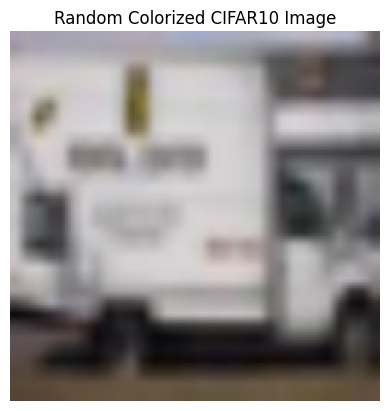

In [21]:
import matplotlib.pyplot as plt
import random

# Get one batch
l_batch, ab_batch = next(iter(dataloader))  # Grab the first batch

# Pick a random image from the batch
idx = random.randint(0, l_batch.size(0) - 1)

l = l_batch[idx]  # [1, H, W]
ab = ab_batch[idx]  # [2, H, W]

# Prepare for display
l_np = l.squeeze(0).cpu().numpy()  # [H, W]
ab_np = ab.cpu().permute(1,2,0).numpy()  # [H, W, 2]

# Recombine into LAB
l_denorm = (l_np * 255).astype('uint8')  # Rescale L
ab_denorm = (ab_np * 128 + 128).astype('uint8')  # Rescale ab

lab = cv2.merge([l_denorm, ab_denorm[:,:,0], ab_denorm[:,:,1]])

# LAB -> BGR -> RGB for display
rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Show
plt.imshow(rgb)
plt.title('Random Colorized CIFAR10 Image')
plt.axis('off')
plt.show()

### Model

In [22]:
class DeepColorizationCNN(nn.Module):
    def __init__(self):
        super(DeepColorizationCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(1, 64, kernel_size=3, padding=0),  # 1 -> 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), 
            nn.MaxPool2d(2, 2),  # downsample
            nn.Dropout2d(0.2),

            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 128, kernel_size=3, padding=0),  # 64 -> 128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # downsample
            nn.Dropout2d(0.2),

            nn.ReflectionPad2d(2), 
            nn.Conv2d(128, 256, kernel_size=5, padding=0),  # 128 -> 256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(2), 
            nn.Conv2d(256, 256, kernel_size=5, padding=0),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # upsample
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # upsample
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),

            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 2, kernel_size=3, padding=0),  # output 2 channels (ab)
            nn.Tanh()  # normalized between [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [23]:
def train(model, optimizer, criterion, num_epochs=10):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for l_batch, ab_batch in loop:
            l_batch = l_batch.to(device)
            ab_batch = ab_batch.to(device)

            output = model(l_batch)
            loss = criterion(output, ab_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

    return losses

### Usage

Epoch 1/10: 100%|██████████| 1563/1563 [12:12<00:00,  2.13it/s, loss=0.833]


Epoch [1/10], Avg Loss: 0.7833


Epoch 2/10: 100%|██████████| 1563/1563 [12:11<00:00,  2.14it/s, loss=0.686]


Epoch [2/10], Avg Loss: 0.7683


Epoch 3/10: 100%|██████████| 1563/1563 [12:21<00:00,  2.11it/s, loss=0.832]


Epoch [3/10], Avg Loss: 0.7637


Epoch 4/10: 100%|██████████| 1563/1563 [12:15<00:00,  2.12it/s, loss=0.676]


Epoch [4/10], Avg Loss: 0.7593


Epoch 5/10: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s, loss=0.751]


Epoch [5/10], Avg Loss: 0.7561


Epoch 6/10: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s, loss=0.745]


Epoch [6/10], Avg Loss: 0.7536


Epoch 7/10: 100%|██████████| 1563/1563 [11:58<00:00,  2.18it/s, loss=0.779]


Epoch [7/10], Avg Loss: 0.7512


Epoch 8/10: 100%|██████████| 1563/1563 [11:55<00:00,  2.19it/s, loss=0.705]


Epoch [8/10], Avg Loss: 0.7491


Epoch 9/10: 100%|██████████| 1563/1563 [11:56<00:00,  2.18it/s, loss=0.702]


Epoch [9/10], Avg Loss: 0.7480


Epoch 10/10: 100%|██████████| 1563/1563 [11:49<00:00,  2.20it/s, loss=0.679]

Epoch [10/10], Avg Loss: 0.7469


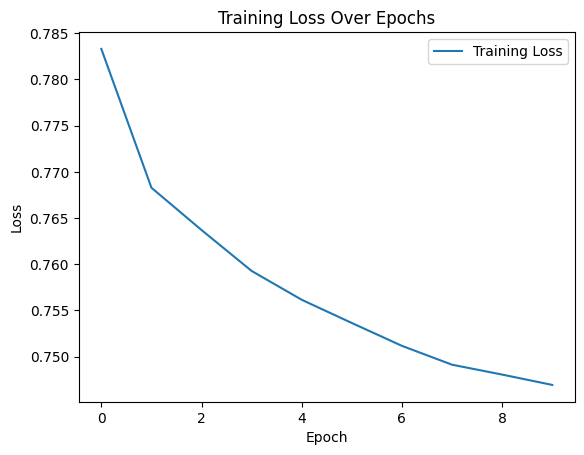

In [24]:
model = DeepColorizationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = train(model, optimizer, criterion)
# Plot the training losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [26]:
torch.save(model.state_dict(), "colorizer.pth")

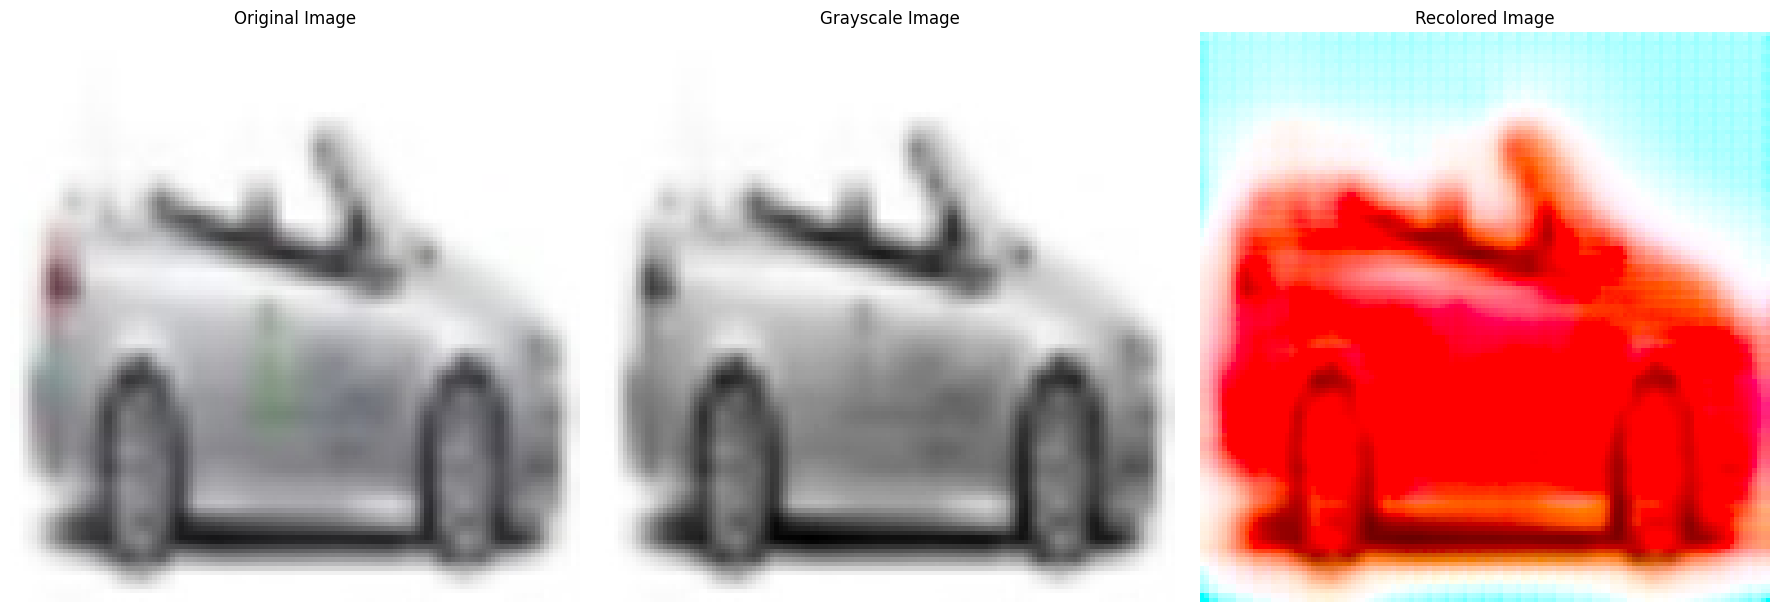

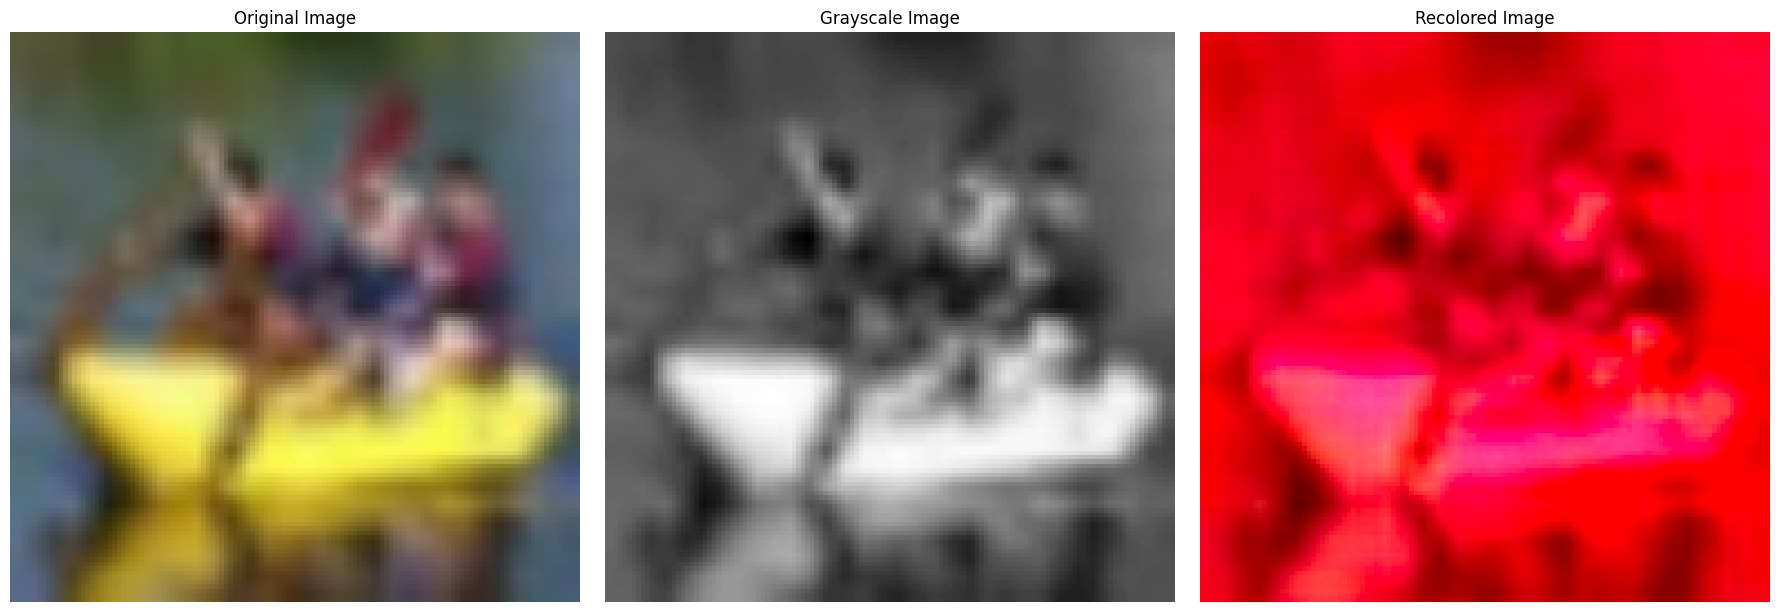

In [27]:
def recolor_image(model, filepath):
    model.eval()  # Set model to evaluation mode

    # 1. Load and preprocess image
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = img[:, :, 0]  # [H, W]

    orig_shape = l_channel.shape  # Save shape for later

    # Normalize L
    l = l_channel / 255.0
    l = torch.tensor(l).unsqueeze(0).unsqueeze(0).float().to(device)  # [1, 1, H, W]

    # 2. Feed through model
    with torch.no_grad():
        pred_ab = model(l)  # [1, 2, H, W]
        pred_ab = pred_ab.squeeze(0).cpu()  # [2, H, W]

    # 3. Postprocess
    pred_ab = pred_ab.permute(1, 2, 0).numpy()  # [H, W, 2]
    pred_ab = (pred_ab * 128) + 128  # Denormalize back to OpenCV format

    # Denormalize L back to [0, 255]
    l_channel = l_channel.astype(np.uint8)

    # Stack L and ab back together
    lab = np.zeros((orig_shape[0], orig_shape[1], 3), dtype=np.uint8)
    lab[:, :, 0] = l_channel
    lab[:, :, 1:] = pred_ab.astype(np.uint8)

    # Convert LAB to BGR (for OpenCV display)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return bgr

import cv2
import matplotlib.pyplot as plt

# 1. Read original image
img = cv2.imread("car.jpg")

# 2. Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. Recolor the image with your model
colorized_image = recolor_image(model, "car.jpg")

# 4. Convert images properly for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Original BGR -> RGB
colorized_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)  # Recolored BGR -> RGB

# 5. Set up a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # (rows=1, cols=3)

# 6. Plot each image
# Original
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Grayscale
axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')

# Recolorized
axes[2].imshow(colorized_rgb)
axes[2].set_title('Recolored Image')
axes[2].axis('off')

# 7. Final clean layout
plt.tight_layout()
plt.show()

img = cv2.imread("raft.jpg")

# 2. Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. Recolor the image with your model
colorized_image = recolor_image(model, "raft.jpg")

# 4. Convert images properly for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Original BGR -> RGB
colorized_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)  # Recolored BGR -> RGB

# 5. Set up a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # (rows=1, cols=3)

# 6. Plot each image
# Original
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Grayscale
axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')

# Recolorized
axes[2].imshow(colorized_rgb)
axes[2].set_title('Recolored Image')
axes[2].axis('off')

# 7. Final clean layout
plt.tight_layout()
plt.show()
